# U-Net CNN for LULC of Aerial Data

In [1]:
# IMPORTS AND RANDOM SEEDS
import os
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from patchify import unpatchify
from patchify import patchify

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

## Configuration

In [58]:
patch_size = 128      # Size to split each training image into
patch_step = 32       # Amount to step when splitting up images for training (<size means some overlap)
percent_augment = 1   # Amount of the training data set to randomly augment (brightness, orientation)
epochs = 150          # Epochs of training for the CNN (early stopping is enabled)

optional_visuals = 1  # Whether or not to show input training data
optional_shapes  = 1  # Whether or not to include optional print statements that check shape data
extra_garbage_collection = 1   # Whether or not to clean up extra memory during execution. Needed for high resolution images or on low memory hardware

## Data Import

In [3]:
path_aerials = "input/aerial/1024"               # Folder with training aerial images
path_labels = "input/label/1024/"                # Folder with matching training labels
path_image_to_predict = "input/full/1024/18.tif" # Path to image to make prediction on

In [4]:
# IMPORT IMAGE, AERIALS AND LABELS FROM FOLDER 
aerials = []
labels = []

# Load aerial image to predict
with rasterio.open(path_image_to_predict) as src:
    full_image = src.read()[0:3] # Remove 4th band (alpha)
    metadata = src.meta.copy()
    

# Load in aerial images
for file in os.listdir(path_aerials):
    with rasterio.open(path_aerials + file) as src:
        image = src.read()[0:3]           # Remove 4th (alpha) band
        image.astype(np.float32) / 255.0  # Normalize to 0-1 range
        aerials.append(image) 

# Load in raster classes
for file in os.listdir(path_labels):
    with rasterio.open(path_labels + file) as src:
        labels.append(src.read()[0])

print(f"Loaded prediction image with shape {full_image.shape}")
print(f"Loaded {len(aerials)} aerials with shape {aerials[0].shape}")
print(f"Loaded {len(labels)} labels with shape {labels[0].shape}")

Loaded prediction image with shape (3, 9216, 9216)
Loaded 7 aerials, with shape (3, 1024, 1024)
Loaded 7 labels, with shape (1024, 1024)


#### ***Optional:*** *Visualize imported data*

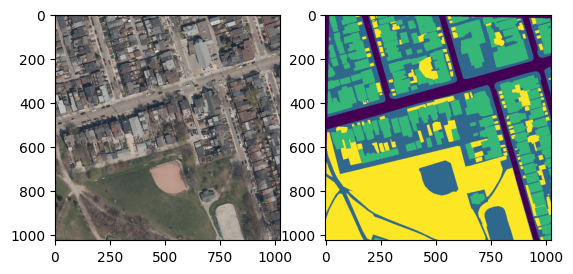

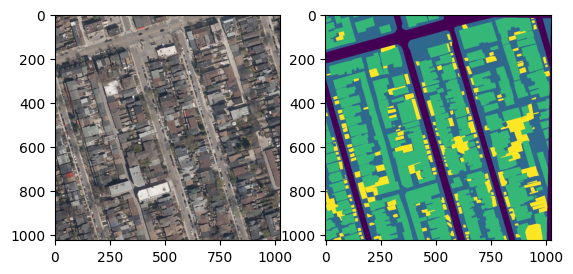

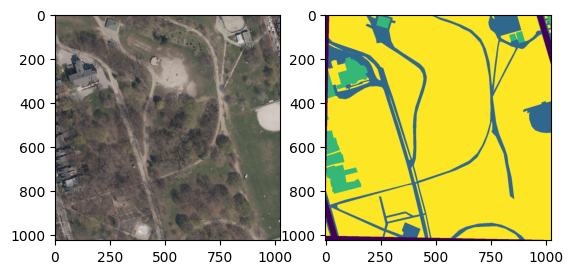

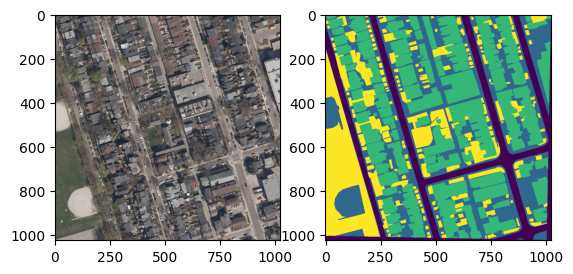

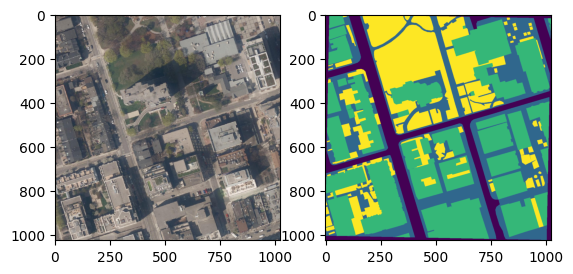

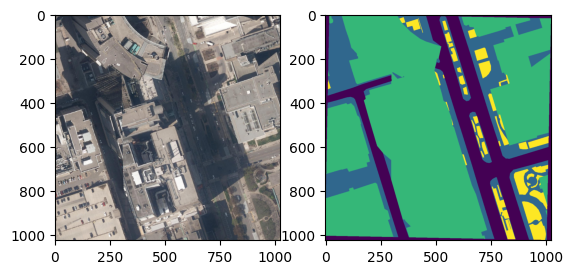

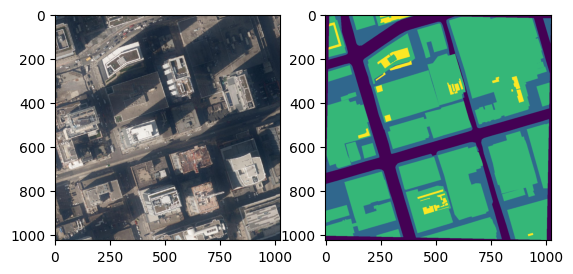

In [5]:
if optional_visuals:
    # Visualize input aerials and labels
    for i in range(len(aerials)):
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(reshape_as_image(aerials[i]))
        ax[1].imshow(labels[i])

## Data Preparation
The input is in the form of a list of aerial images and a list of matching labels (raster). The processing step will achieve the following:
- Encode raster labels to be categorical
- Split testing data off (X_train, X_test, Y_train, Y_test)
- Create overlapping patches in the training and test set
- Augment training data

### Convert class labels to categorical (one-hot encoding)

In [6]:
# ONE HOT ENCODE
num_classes = len(np.unique(labels))
labels_encoded = to_categorical(labels, num_classes=num_classes)

if optional_shapes: print(labels_encoded.shape)

(7, 1024, 1024, 4)


### Train-Test split
Testing data is split off from the training data before overlapping patches are created, so that there is no overlap between the border regions of the training and test sets. This would cause a data leakage issue where some regions appear in both sets. 

In [7]:
# TRAIN TEST SPLIT
aerial_train, aerial_test, label_train, label_test = [], [], [], []
split_x = int(aerials[0].shape[1] * 0.75) 

# Split end range of images off for testing
for i in range(len(aerials)):
    aerial_train.append(aerials[i][:, :, :split_x])
    aerial_test.append(aerials[i][:, :, split_x:])

    label_train.append(labels_encoded[i][:, :split_x, :])
    label_test.append(labels_encoded[i][:, split_x:, :])

if optional_shapes:
    print(f"aerial_train: {len(aerial_train), aerial_train[0].shape}")
    print(f"aerial_test: {len(aerial_test), aerial_test[0].shape}")
    print(f"label_train: {len(label_train), label_train[0].shape}")
    print(f"label_test: {len(label_test), label_test[0].shape}")

aerial_train: (7, (3, 1024, 768))
aerial_test: (7, (3, 1024, 256))
label_train: (7, (1024, 768, 4))
label_test: (7, (1024, 256, 4))


### Create Image Patches
The input images must be split into smaller samples before training the model, achieved using Patchify. By setting a patch step smaller than the patch size, the resulting patches overlap. This can help to expand the training set and give the model better spatial representation, especially on border regions between patches.

Through experimentation, the ideal ratio for this purpose and data set appears to be around `patch_size = patch_step * 4`

In [8]:
# CREATE OVERLAPPING PATCHES
patches_aerial_train, patches_aerial_test = [], []
patches_label_train, patches_label_test = [], []

# Patchify each train and test region
for i in range(len(aerial_train)):
    patches_aerial_train.append(patchify(aerial_train[i], (3, patch_size, patch_size), step=patch_step)[0])
    patches_aerial_test.append(patchify(aerial_test[i], (3, patch_size, patch_size), step=patch_step)[0])
    
    patches_label_train.append(patchify(label_train[i], (patch_size, patch_size, num_classes), step=patch_step))
    patches_label_test.append(patchify(label_test[i], (patch_size, patch_size, num_classes), step=patch_step))

# Convert lists to np array so that they can be reshaped and transposed
patches_aerial_train = np.array(patches_aerial_train)
patches_aerial_test = np.array(patches_aerial_test)
patches_label_train = np.array(patches_label_train)
patches_label_test = np.array(patches_label_test)

# Reshape and transpose into one list of patches
patches_aerial_train = patches_aerial_train.reshape(-1, 3, patch_size, patch_size)
patches_aerial_train = np.transpose(patches_aerial_train, (0, 2, 3, 1))

patches_aerial_test = patches_aerial_test.reshape(-1, 3, patch_size, patch_size)
patches_aerial_test = np.transpose(patches_aerial_test, (0, 2, 3, 1))

patches_label_train = patches_label_train.reshape(-1, patch_size, patch_size, num_classes)
patches_label_test = patches_label_test.reshape(-1, patch_size, patch_size, num_classes)

if optional_shapes:
    print(f"aerial train: {patches_aerial_train.shape}")
    print(f"aerial test: {patches_aerial_test.shape}")
    print(f"label train: {patches_label_train.shape}")
    print(f"label test: {patches_label_test.shape}")

aerial train: (4263, 128, 128, 3)
aerial test: (1015, 128, 128, 3)
label train: (4263, 128, 128, 4)
label test: (1015, 128, 128, 4)


## Data Augmentation
Neural networks can enhance performance by useing augmented training data. This section will randomize brightness, contrast, saturation, and hue, randomly horizontally flip, rotate, and zoom, and add small amounts of noise. The purpose here is to help the model recognize features in slightly different conditions (a road in a shadow, for example).

In [56]:
# AUGMENTATION FUNCTION
def augment(image, label, brightness_factor=0.2, flip_prob=0.5, rotate_prob=0.5, noise_prob=0.5, zoom_prob=0.2):
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=brightness_factor)

    # Random contrast
    image  = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random hue
    image = tf.image.random_hue(image, max_delta=0.05)
    
    # Random horizontal flipping
    if tf.random.uniform([]) < flip_prob:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random rotation (90, 180, 270)
    if tf.random.uniform([]) < rotate_prob:
        k = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        label = tf.image.rot90(label, k=k)

    # Gaussian noise
    if tf.random.uniform([]) < noise_prob:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Random zoon
    if tf.random.uniform([]) < zoom_prob:
        crop_factor = tf.random.uniform([], minval=0.7, maxval=1.0)
        h, w, _ = image.shape
        new_h = tf.cast(h * crop_factor, tf.int32)
        new_w = tf.cast(w * crop_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, new_h, new_w)
        label = tf.image.resize_with_crop_or_pad(label, new_h, new_w)

        image = tf.image.resize(image, [h,w])
        label = tf.image.resize(label, [h,w])

    return image, label

In [10]:
# EXECUTE AUGMENTATION
# Randomly select indices for augmentation
num_aug_samples = int(percent_augment * patches_aerial_train.shape[0])
augment_indices = np.random.choice(patches_aerial_train.shape[0], num_aug_samples, replace=False)

# Apply augmentation
X_aug = []
Y_aug = []

for idx in augment_indices:
    new_image, new_label = augment(patches_aerial_train[idx], patches_label_train[idx])
    X_aug.append(np.array(new_image))  
    Y_aug.append(np.array(new_label))
    
# Convert to np array and concatenate with original dataset
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

X_train = np.concatenate([patches_aerial_train, X_aug], axis=0)
Y_train = np.concatenate([patches_label_train, Y_aug], axis=0)

X_test = patches_aerial_test
Y_test = patches_label_test

print(f"Added {num_aug_samples} augmented images. New training total: {X_train.shape[0]}")

Added 4263 augmented images. New training total: 8526


## Build U-Net CNN Model
Simple U-Net architecture. Strong for image based semantic segmentation of this type. This means it should identify areas of each class (e.g. building, road), but will not perform instance segmentation (i.e. recognizing distinct building footprints from each other in close proximity).

In [57]:
# COMPILE MODEL
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),  # Upsample back

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(num_classes, (1,1), activation='softmax')  # Output "num_classes" classes per pixel
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

C:\Users\Connor\Documents\Code\QGIS\to-lulc-aiml\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Fit the Model
With the model defined, it can now be fit to the training data. Early stopping is enabled based on validation loss, so (resource permitting) epochs can be set high. In experimentaiton, more than 40 epochs have not been necessary before experiencing validation loss.

In [12]:
# TRAIN MODEL
# Enable early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test),
                    epochs=epochs, batch_size=32, 
                    callbacks=[early_stopping],
                   )

Epoch 1/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 85s 308ms/step - accuracy: 0.4253 - loss: 1.8721 - val_accuracy: 0.5459 - val_loss: 1.1383
Epoch 2/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.5241 - loss: 1.1267 - val_accuracy: 0.5682 - val_loss: 1.0321
Epoch 3/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 80s 300ms/step - accuracy: 0.5803 - loss: 0.9780 - val_accuracy: 0.6071 - val_loss: 0.9375
Epoch 4/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.6368 - loss: 0.8482 - val_accuracy: 0.6153 - val_loss: 0.9503
Epoch 5/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 291ms/step - accuracy: 0.6863 - loss: 0.7352 - val_accuracy: 0.6261 - val_loss: 1.0033
Epoch 6/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.7148 - loss: 0.6680 - val_accuracy: 0.6125 - val_loss: 1.1396
Epoch 7/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.7313 - loss: 0.6295 - val_accuracy: 0.6250 - val_loss: 1.2016
Epoch 8/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.7463 -

### Evaluate Accuracy
Check the accuracy and loss over the epochs. Mostly interested in overall validation accuracy (how well did it perform on novel test images after training).

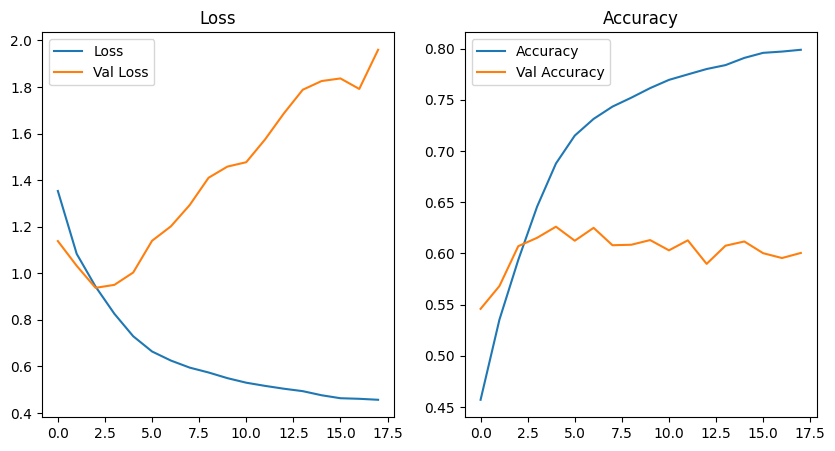

In [13]:
# Plot training loss & accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()

## Predict Full Area
With the model trained it can now be used to predict land use classes for a new aerial image. The image will be split into patches of the same size as the training patches, but can be set to have a different step for more or less overlap. More overlap produces (diminishingly) smoother results at the cost of much more memory during the prediction phase. Once averaged back into one image however, the resulting output should be the same size. 

In [50]:
# PATCHIFY IMAGE TO PREDICT
patch_step_pred = patch_size // 4
full_image_reshaped = reshape_as_image(full_image)
if optional_shapes: print("Full Image shape:", full_image_reshaped.shape)  

# Turn full image into patches to be predicted 
patches_full = patchify(full_image_reshaped, (patch_size, patch_size, 3), step=patch_step_pred)
patches_full_x, patches_full_y = patches_full.shape[0:2]

# Turn 2D array of patches into one list of patches i.e. (num_patches, patch_size, patch_size, bands)
patches_full_reshaped = patches_full.reshape(-1, patch_size, patch_size, 3)
if optional_shapes: print("Reshaped for Model shape:", patches_full_reshaped.shape)  

Full Image shape: (9216, 9216, 3)
Reshaped for Model shape: (81225, 128, 128, 3)


#### Predict patches in batches
To reduce likelihood of crashing due to an out of memory exception, high resolution images should be predicted in batches of patches, instead of all at once.

In [59]:
# PREDICT IMAGE PATCHES
# Predict the full image in batches to avoid memory constraints
batch_size = 4096
num_patches = patches_full_reshaped.shape[0]
predictions_list = []

# Batch predictions
for start in range(0, num_patches, batch_size):
    end = min(start + batch_size, num_patches)
    batch_patches = patches_full_reshaped[start:end]
    preds = model.predict(batch_patches)
    predictions_list.append(preds)

# Concatenate predictions
predictions = np.concatenate(predictions_list, axis=0)

# Reshape back to original
predictions = predictions.reshape(patches_full.shape[0], patches_full.shape[1], patch_size, patch_size, -1)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=-1)

NameError: name 'patches_full_reshaped' is not defined

In [52]:
# OPTIONAL EXTRA GARBAGE COLLECTION 
# For memory management
if extra_garbage_collection:
    import gc
    del predictions, patches_full_reshaped
    gc.collect()

4849

#### Reassemble the Image from Predicted Patches
Put the prediction patches into one image. To deal with the overlap, and average blend is taken. A guassian blend was attempted but created worse results given the square grid nature of the roadway network being predicted in Toronto.

Full prediction shape: (9248, 9248)


C:\Users\Connor\AppData\Local\Temp\ipykernel_35404\858059022.py:20: RuntimeWarning: invalid value encountered in divide
  full_prediction = (full_prediction / weight_matrix).astype(np.float32)
C:\Users\Connor\AppData\Local\Temp\ipykernel_35404\858059022.py:21: RuntimeWarning: invalid value encountered in cast
  full_prediction = full_prediction.astype(np.uint8)


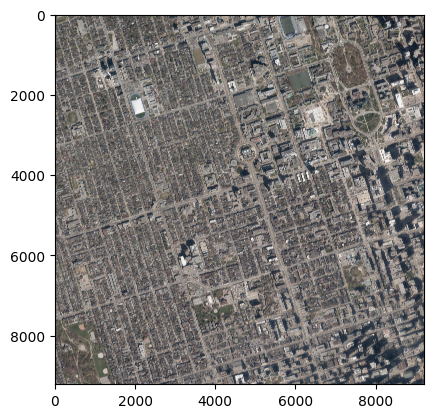

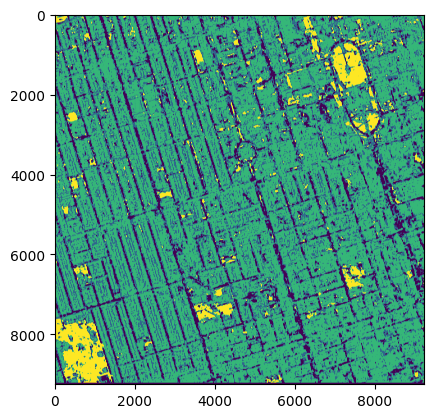

Input Aerials: 7 
Dim Aerials: (3, 1024, 1024) 
Patch Size, Step: (128, 32) 
Prediction Size: (3, 9216, 9216)


In [53]:
# REASSEMBLE IMAGE
# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_step_pred + patch_size, 
                            patches_full_y * patch_step_pred + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)

# Blend patches (average blending)
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_step_pred
        x_end = x_start + patch_size
        y_start = j * patch_step_pred
        y_end = y_start + patch_size
        
        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j]
        weight_matrix[x_start:x_end, y_start:y_end] += 1  # Track contributions

# Normalize by the number of times each pixel was predicted
full_prediction = (full_prediction / weight_matrix).astype(np.float32)
full_prediction = full_prediction.astype(np.uint8)

# Patch results and display
rasterio.plot.show(full_image)
rasterio.plot.show(full_prediction)

print(f"Input Aerials: {len(aerials)} \nDim Aerials: {aerials[0].shape} \nPatch Size, Step: {(patch_size, patch_step)} \nPrediction Size: {full_image.shape}")

## Export Result
Used to export the resulting prediction. The output classes are scaled to be spread between 0 and 255 so that they are immediately interpretable. In QGIS or other software, either the new values can be colour cast, or the output can be exported with its original classes (0-3) but will look black without colour assignment elsewhere.

In [54]:
# Rescale predictions for visualization/export
scaled_prediction = full_prediction.astype(np.float32) * (255.0 / 3.0)
scaled_prediction = np.clip(scaled_prediction, 0, 255).astype(np.uint8)

# Use original metadata
metadata.update({
    "dtype": "uint8",  # Match predicted dtype
    "count": 1,        # Single band output
})

# Save the prediction as a GeoTIFF
output_path = f"output/{len(aerials)}aerials_{aerials[0].shape[1]}in_res_{full_image.shape[1]}out_res_{patch_size}patch_{patch_step}step_{patch_step_pred}pred_step.tif"
with rasterio.open(output_path, "w", **metadata) as dst:
    dst.write(scaled_prediction, 1)
print(f"Prediction saved to {output_path}")

Prediction saved to output/7aerials_1024in_res_9216out_res_128patch_32step_32pred_step.tif
